In [1]:
import networkx as nx
from networkx.algorithms import tree
from tools import dependency, sentence_attentions
from tools.dependency_converter import DependencyConverter
from sklearn.metrics import confusion_matrix

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np

from itertools import cycle, islice

from tqdm import tqdm

from collections import defaultdict, namedtuple
import pandas as pd
%matplotlib inline

In [2]:
dev = True
if dev:
    attention_file = '../BertAA/BertAA-dev/attentions.npz'
    token_file = '../BertAA/BertAA-dev/source.txt'
    conllu_file_name = '../graph-extraction/endev-conv.conllu'
    no_softmax = False
else:
    attention_file = '../BertAA/attentions.npz'
    token_file = '../BertAA/source.txt'
    conllu_file_name = '../data/entest-conv.conllu'
    no_softmax = True
    
conllu_train_file = '../graph-extraction/entrain-conv.conllu'
    

In [3]:
maxlen = 1000

fontsize=8

#this is necessary in this case
eos = True
#no_softmax = False

dependency.define_labels(True)

dependency_rels = dependency.read_conllu_labeled(conllu_file_name)


dependency_rels = [DependencyConverter(sent_rel).convert(return_root=True) for sent_rel in dependency_rels]

with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]
    
attentions_loaded = np.load(attention_file)
sentences_count = 1000
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]

tokens_grouped, common_tokens = dependency.group_wordpieces(tokens_loaded, conllu_file_name)

## Multigraphs

In [4]:
all_pos = set()
for sent_rels in dependency_rels:
    for dep, head, label, pos in sent_rels:
        all_pos.add(pos)

In [5]:
def pos_dict():
    all_pos = {'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN','NUM',
    'PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X'}
    
    res_dict = dict()
    for pos1 in all_pos:
        for pos2 in all_pos:
            res_dict[(pos1,pos2)] = 0
    return res_dict

In [6]:
pos_frame = dependency.conllu2freq_frame(conllu_train_file )
RelData= namedtuple('RelData','layers heads transpose d2p')

In [7]:
relation_rules  = {'adj-clause-p2d': RelData([3, 4, 7, 6, 5, 7], [3, 5, 6, 6, 9, 10],False, False),
        'adj-modifier-p2d': RelData([7, 0, 5, 6], [4, 3, 10, 4],False, False),
        'adv-clause-p2d': RelData([5, 3, 4, 5, 1], [8, 3, 8, 11, 5],False, False),
        'adv-modifier-p2d': RelData([7, 5, 6, 4, 9, 4], [7, 1, 9, 7, 3, 10],False, False),
        'all-p2d': RelData([1, 3, 6, 7, 0, 4, 7, 9], [4, 5, 11, 4, 2, 7, 7, 3],False, False),
        'apposition-p2d': RelData([3], [3],False, False),
        'auxiliary-p2d': RelData([7, 6, 1, 8, 1, 9, 8], [3, 2, 10, 11, 6, 4, 4],False, False),
        'clausal subject-p2d': RelData([7, 7], [1, 10],False, False),
        'clausal-p2d': RelData([5, 7, 7, 7, 4, 3, 5, 0, 6, 1], [8, 10, 1, 6, 5, 3, 11, 8, 6, 5],False, False),
        'compound-p2d': RelData([3, 1, 0], [5, 4, 3],False, False),
        'conjunct-p2d': RelData([5, 9, 7, 3, 10, 4, 11], [5, 6, 8, 3, 5, 8, 8],False, False),
        'determiner-p2d': RelData([0, 6, 2, 6, 1], [3, 9, 1, 3, 4],False, False),
        'i object-p2d': RelData([3], [9],False, False),
        'noun-modifier-p2d': RelData([4, 5, 3, 3, 5], [5, 0, 3, 9, 9],False, False),
        'num-modifier-p2d': RelData([7, 4, 0, 6, 5], [11, 7, 2, 9, 9],False, False),
        'object-p2d': RelData([3, 5, 5, 7], [9, 0, 9, 10],False, False),
        'other-p2d': RelData([8, 6, 9, 5, 1, 7, 0, 3, 1], [6, 9, 3, 6, 4, 7, 2, 5, 10],False, False),
        'punctuation-p2d': RelData([5, 6], [10, 11],False, False),
        'subject-p2d': RelData([7, 4, 6], [4, 10, 4],False, False)}

In [8]:
relation_rules  = {'adj-clause-p2d': RelData([3, 4, 7, 6, 5, 7], [3, 5, 6, 6, 9, 10],False, False),
        'adj-modifier-p2d': RelData([7, 0, 5, 6], [4, 3, 10, 4],False, False),
        'adv-clause-p2d': RelData([5, 3, 4, 5, 1], [8, 3, 8, 11, 5],False, False),
        'adv-modifier-p2d': RelData([7, 5, 6, 4, 9, 4], [7, 1, 9, 7, 3, 10],False, False),
        'all-p2d': RelData([1, 3, 6, 7, 0, 4, 7, 9], [4, 5, 11, 4, 2, 7, 7, 3],False, False),
        'apposition-p2d': RelData([3], [3],False, False),
        'auxiliary-p2d': RelData([7, 6, 1, 8, 1, 9, 8], [3, 2, 10, 11, 6, 4, 4],False, False),
        'clausal subject-p2d': RelData([7, 7], [1, 10],False, False),
        'clausal-p2d': RelData([5, 7, 7, 7, 4, 3, 5, 0, 6, 1], [8, 10, 1, 6, 5, 3, 11, 8, 6, 5],False, False),
        'compound-p2d': RelData([3, 1, 0], [5, 4, 3],False, False),
        'conjunct-p2d': RelData([5, 9, 7, 3, 10, 4, 11], [5, 6, 8, 3, 5, 8, 8],False, False),
        'determiner-p2d': RelData([0, 6, 2, 6, 1], [3, 9, 1, 3, 4],False, False),
        'i object-p2d': RelData([3], [9],False, False),
        'noun-modifier-p2d': RelData([4, 5, 3, 3, 5], [5, 0, 3, 9, 9],False, False),
        'num-modifier-p2d': RelData([7, 4, 0, 6, 5], [11, 7, 2, 9, 9],False, False),
        'object-p2d': RelData([3, 5, 5, 7], [9, 0, 9, 10],False, False),
        'other-p2d': RelData([8, 6, 9, 5, 1, 7, 0, 3, 1], [6, 9, 3, 6, 4, 7, 2, 5, 10],False, False),
        'punctuation-p2d': RelData([5, 6], [10, 11],False, False),
        'subject-p2d': RelData([7, 4, 6], [4, 10, 4],False, False)}


In [9]:
relation_rules  = {'adj-clause-d2p': RelData([6, 6, 3, 0, 7], [9, 2, 11, 3, 9],False, True),
    'adj-modifier-d2p': RelData([3, 7, 4, 5], [9, 2, 5, 0],False, True),
    'adv-clause-d2p': RelData([6, 5, 4, 1, 8, 4, 3], [2, 3, 10, 10, 4, 9, 11],False, True),
    'adv-modifier-d2p': RelData([5, 6, 7, 3, 5, 4, 10, 6], [9, 6, 6, 9, 0, 5, 10, 3],False, True),
    'all-d2p': RelData([6, 7, 3, 8, 7, 6, 1, 9, 5], [6, 2, 9, 5, 6, 5, 6, 3, 11],False, True),
    'apposition-d2p': RelData([4, 3], [10, 11],False, True),
    'auxiliary-d2p': RelData([7, 3, 5, 4, 1, 1], [2, 9, 9, 11, 6, 1],False, True),
    'clausal subject-d2p': RelData([5, 5], [2, 3],False, True),
    'clausal-d2p': RelData([6, 5, 7, 7], [2, 3, 0, 9],False, True),
    'compound-d2p': RelData([3, 7], [9, 2],False, True),
    'conjunct-d2p': RelData([6, 9, 8, 4, 3, 11], [0, 6, 4, 10, 11, 9],False, True),
    'determiner-d2p': RelData([7, 3, 4], [10, 9, 5],False, True),
    'i object-d2p': RelData([5], [1],False, True),
    'noun-modifier-d2p': RelData([6, 3, 7, 6], [9, 11, 9, 2],False, True),
    'num-modifier-d2p': RelData([0, 9], [10, 3],False, True),
    'object-d2p': RelData([6, 3, 6], [9, 11, 10],False, True),
    'other-d2p': RelData([5, 4, 8, 6, 3, 5, 7, 7, 7, 5, 1, 1], [0, 5, 5, 6, 9, 7, 1, 2, 6, 9, 6, 1],False, True),
    'punctuation-d2p': RelData([7, 8, 8, 5, 7, 8], [1, 5, 0, 7, 6, 4],False, True),
    'subject-d2p': RelData([7, 6, 5, 5, 1, 7, 5, 7, 4], [2, 6, 9, 0, 6, 1, 11, 8, 11],False, True)}


In [10]:
# diagonal mask
relation_rules  = {'adj-clause-p2d': RelData([4, 7, 6, 0], [5, 6, 5, 8],False, False),
    'adj-modifier-d2p': RelData([3, 7, 6, 5, 7, 8, 0, 2], [9, 10, 5, 7, 6, 5, 8, 11],False, True),
    'adv-clause-d2p': RelData([4, 4, 5, 4, 2, 0], [9, 3, 4, 4, 7, 7],False, True),
    'adv-modifier-d2p': RelData([7, 5, 6, 8, 7, 3, 10, 0, 6, 0], [6, 7, 5, 5, 10, 10, 10, 8, 4, 11],False, True),
    'apposition-p2d': RelData([0, 9], [8, 0],False, False),
    'auxiliary-d2p': RelData([3, 8, 7, 5, 4, 7, 10], [9, 5, 6, 0, 5, 10, 10],False, True),
    'clausal subject-p2d': RelData([8, 0, 0, 0], [10, 8, 5, 1],False, False),
    'clausal-d2p': RelData([7, 6, 4, 8, 5, 0, 0, 1, 0], [0, 2, 6, 8, 4, 5, 9, 11, 7],False, True),
    'compound-d2p': RelData([3, 7, 6, 7, 0], [9, 6, 5, 10, 8],False, True),
    'conjunct-d2p': RelData([4, 6, 4, 9, 5, 1, 0, 4, 6], [3, 0, 9, 6, 4, 10, 1, 4, 8],False, True),
    'determiner-d2p': RelData([7, 3, 4, 8], [10, 9, 5, 10],False, True),
    'i object-d2p': RelData([6], [9],False, True),
    'noun-modifier-p2d': RelData([4, 0, 9, 5, 3, 0, 0], [5, 8, 1, 8, 3, 1, 5],False, False),
    'num-modifier-d2p': RelData([7, 6, 3, 8, 7, 6, 0, 10], [10, 5, 10, 5, 6, 4, 11, 10],False, True),
    'object-d2p': RelData([7, 6, 4, 5, 3], [9, 9, 6, 3, 8],False, True),
    'other-d2p': RelData([7, 4, 8, 6, 3, 0], [10, 5, 5, 5, 10, 8],False, True),
    'punctuation-p2d': RelData([11, 10, 2, 11, 7, 7], [6, 7, 2, 2, 8, 7],False, False),
    'subject-p2d': RelData([7, 4], [11, 10],False, False)}


In [11]:
# diagonal mask
relation_rules  = {'adj-clause-p2d': RelData([4, 7, 6, 0], [5, 6, 5, 8],False, False),
    'adj-modifier-d2p': RelData([3, 7, 6, 5, 7, 8, 0, 2], [9, 10, 5, 7, 6, 5, 8, 11],False, True),
    'adv-clause-p2d': RelData([4, 5, 5, 0, 4, 5, 11, 8, 3, 0], [3, 4, 5, 8, 9, 8, 8, 7, 1, 4],False, False),
    'adv-modifier-d2p': RelData([7, 5, 6, 8, 7, 3, 10, 0, 6, 0], [6, 7, 5, 5, 10, 10, 10, 8, 4, 11],False, True),
    'apposition-p2d': RelData([0, 9], [8, 0],False, False),
    'auxiliary-d2p': RelData([3, 8, 7, 5, 4, 7, 10], [9, 5, 6, 0, 5, 10, 10],False, True),
    'clausal subject-p2d': RelData([8, 0, 0, 0], [10, 8, 5, 1],False, False),
    'clausal-p2d': RelData([5, 4, 7, 5, 0, 7, 4], [7, 5, 6, 8, 8, 1, 8],False, False),
    'compound-d2p': RelData([3, 7, 6, 7, 0], [9, 6, 5, 10, 8],False, True),
    'conjunct-d2p': RelData([4, 6, 4, 9, 5, 1, 0, 4, 6], [3, 0, 9, 6, 4, 10, 1, 4, 8],False, True),
    'determiner-d2p': RelData([7, 3, 4, 8], [10, 9, 5, 10],False, True),
    #'i object-d2p': RelData([6], [9],False, True),
    'noun-modifier-p2d': RelData([4, 0, 9, 5, 3, 0, 0], [5, 8, 1, 8, 3, 1, 5],False, False),
    'num-modifier-d2p': RelData([7, 6, 3, 8, 7, 6, 0, 10], [10, 5, 10, 5, 6, 4, 11, 10],False, True),
    'object-d2p': RelData([7, 6, 4, 5, 3], [9, 9, 6, 3, 8],False, True),
    'other-d2p': RelData([7, 4, 8, 6, 3, 0], [10, 5, 5, 5, 10, 8],False, True),
    'punctuation-d2p': RelData([4, 8, 3, 7, 3], [5, 5, 10, 5, 9],False, True),
    'subject-p2d': RelData([7, 4], [11, 10],False, False)
    }


In [12]:
# soft pos aggegated relation types BEST
relation_rules  = {'adj-clause-p2d': RelData([3, 4, 7, 6, 5, 7], [3, 5, 6, 6, 9, 10],False, False),
    'adj-modifier-d2p': RelData([3, 7, 4, 5], [9, 2, 5, 0],False, True),
    'adv-clause-p2d': RelData([5, 3, 4, 5, 1], [8, 3, 8, 11, 5],False, False),
    'adv-modifier-p2d': RelData([7, 5, 6, 4, 9, 4], [7, 1, 9, 7, 3, 10],False, True),
    'apposition-p2d': RelData([3], [3],False, False),
    'auxiliary-d2p': RelData([7, 3, 5, 4, 1, 1], [2, 9, 9, 11, 6, 1],False, True),
    'clausal-p2d': RelData([5, 7, 7, 7, 4, 3, 5, 0, 6, 1], [8, 10, 1, 6, 5, 3, 11, 8, 6, 5],False, False),
    'clausal-d2p': RelData([6, 5, 7, 7], [2, 3, 0, 9],False, True),
    'compound-d2p': RelData([3, 7], [9, 2],False, True),
    'conjunct-d2p': RelData([6, 9, 8, 4, 3, 11], [0, 6, 4, 10, 11, 9],False, True),
    'determiner-d2p': RelData([7, 3, 4], [10, 9, 5],False, True),
    #'i object-d2p': RelData([5], [1],False, True),
    'noun-modifier-d2p': RelData([6, 3, 7, 6], [9, 11, 9, 2],False, True),
    'num-modifier-p2d': RelData([7, 4, 0, 6, 5], [11, 7, 2, 9, 9],False, False),
    'object-d2p': RelData([6, 3, 6], [9, 11, 10],False, True),
    'other-d2p': RelData([5, 4, 8, 6, 3, 5, 7, 7, 7, 5, 1, 1], [0, 5, 5, 6, 9, 7, 1, 2, 6, 9, 6, 1],False, True),
    'punctuation-d2p': RelData([7, 8, 8, 5, 7, 8], [1, 5, 0, 7, 6, 4],False, True),
    'subject-p2d': RelData([7, 4, 6], [4, 10, 4],False, False)}


In [13]:
#soft pos all relation types
relation_rules  = {'acl-p2d': RelData([3, 4, 7, 6, 5, 7], [3, 5, 6, 6, 9, 10],False, False),
    'advcl-p2d': RelData([5, 3, 4, 5, 1], [8, 3, 8, 11, 5],False, False),
    'advmod-p2d': RelData([7, 5, 6, 4, 9, 4], [7, 1, 9, 7, 3, 10],False, False),
    'amod-d2p': RelData([3, 7, 4, 5], [9, 2, 5, 0],False, True),
    'appos-p2d': RelData([3], [3],False, False),
    'aux-d2p': RelData([7, 3, 5, 4, 1, 1], [2, 9, 9, 11, 6, 1],False, True),
    'case-p2d': RelData([0, 5, 3, 9, 1], [3, 10, 11, 3, 4],False, False),
    'cc-p2d': RelData([5, 3, 0, 6, 7, 7], [10, 11, 3, 9, 9, 4],False, False),
    'ccomp-d2p': RelData([6, 5, 7, 7], [2, 3, 0, 9],False, True),
    'compound-d2p': RelData([3, 7], [9, 2],False, True),
    'conj-p2d': RelData([5, 9, 7, 3, 10, 4, 11], [5, 6, 8, 3, 5, 8, 8],False, False),
    'csubj-p2d': RelData([7, 7], [1, 10],False, False),
    'det-p2d': RelData([0, 6, 2, 6, 1], [3, 9, 1, 3, 4],False, False),
    'discourse-p2d': RelData([11], [11],False, False),
    'expl-p2d': RelData([5], [9],False, False),
    'fixed-d2p': RelData([8], [6],False, True),
    'flat-p2d': RelData([8], [5],False, False),
    'iobj-p2d': RelData([3], [9],False, False),
    'mark-p2d': RelData([7, 6, 5, 0, 6, 7, 8], [9, 9, 6, 3, 10, 4, 11],False, False),
    'nmod-d2p': RelData([6, 3, 7, 6], [9, 11, 9, 2],False, True),
    'nsubj-d2p': RelData([7, 6, 5, 5, 1, 7, 5, 7, 4], [2, 6, 9, 0, 6, 1, 11, 8, 11],False, True),
    'nummod-p2d': RelData([7, 4, 0, 6, 5], [11, 7, 2, 9, 9],False, False),
    'obj-d2p': RelData([6, 3, 6], [9, 11, 10],False, True),
    'parataxis-p2d': RelData([5], [5],False, False),
    'punct-p2d': RelData([5, 6], [10, 11],False, False),
    'vocative-p2d': RelData([6], [9],False, False),
    'xcomp-d2p': RelData([6, 3, 5, 5], [9, 11, 6, 3],False, True)}


In [14]:
#hard pos all relation types
relation_rules  = {'acl-p2d': RelData([4, 7, 6, 3, 0, 5], [5, 6, 6, 9, 10, 8],False, False),
    'advcl-p2d': RelData([4, 3, 5, 5], [8, 3, 8, 5],False, False),
    'advmod-p2d': RelData([5, 6, 7, 4, 9, 3, 0, 2], [1, 4, 7, 7, 3, 11, 11, 1],False, False),
    'amod-d2p': RelData([3, 7, 4, 6, 5, 9, 7], [9, 2, 5, 5, 0, 3, 8],False, True),
    'appos-p2d': RelData([3, 7, 6], [3, 2, 6],False, False),
    'aux-d2p': RelData([7, 3, 5, 5, 6, 4, 1], [6, 9, 7, 0, 5, 5, 6],False, True),
    'case-p2d': RelData([0, 5, 8, 1, 4], [3, 10, 6, 4, 10],False, False),
    'cc-p2d': RelData([3, 6, 5, 7], [11, 9, 6, 3],False, False),
    'ccomp-d2p': RelData([7, 6, 10], [0, 2, 0],False, True),
    'compound-d2p': RelData([3, 6, 7, 5, 4, 9, 5], [9, 6, 2, 0, 5, 3, 11],False, True),
    'conj-p2d': RelData([5, 9, 10, 3, 6, 7, 11, 4, 10, 10], [5, 6, 5, 3, 8, 8, 8, 8, 9, 1],False, False),
    'csubj-p2d': RelData([7, 7], [10, 1],False, False),
    'dep-d2p': RelData([7, 9, 7, 5], [9, 3, 2, 3],False, True),
    'det-p2d': RelData([0, 5, 2, 6, 1, 6], [3, 6, 1, 3, 4, 11],False, False),
    'discourse-p2d': RelData([2, 11], [9, 11],False, False),
    'fixed-d2p': RelData([5], [6],False, True),
    'flat-p2d': RelData([8], [5],False, False),
                   
    'mark-d2p': RelData([7, 8, 7, 5, 4, 6, 5], [1, 5, 6, 7, 5, 6, 11],False, True),
    'nmod-d2p': RelData([7, 6, 3, 6, 5, 8], [9, 9, 11, 2, 3, 11],False, True),
    'nsubj-p2d': RelData([7], [4],False, False),
    'nummod-p2d': RelData([7, 0, 5, 6, 6], [11, 2, 10, 6, 11],False, False),
    'obj-d2p': RelData([6, 1], [9, 10],False, True),
    'parataxis-p2d': RelData([6, 3, 0], [8, 0, 4],False, False),
    'punct-p2d': RelData([2, 2, 5, 7, 6, 2, 7, 6, 0, 6, 3, 5, 1, 8, 0, 3, 6], [0, 9, 10, 7, 9, 1, 4, 11, 3, 3, 11, 6, 4, 6, 2, 5, 2],False, False),
    'vocative-p2d': RelData([6, 8, 7], [9, 4, 2],False, False),
    'xcomp-d2p': RelData([3, 6, 6], [11, 2, 4],False, True)}

## Multigraph arborescene

In [15]:
# no softmax before averaging required
def average_matrices(matrices,layers, heads, transpose=False):
    sel_matrices = matrices[layers,heads,:,:]
    if transpose:
        sel_matrices = sel_matrices.transpose([0, 2, 1])
    sel_matrices -= sel_matrices.max(axis=-1, keepdims=True)
    sel_matrices = np.exp(sel_matrices)
    sel_matrices = sel_matrices/sel_matrices.sum(axis=-1, keepdims=True)
    
    return np.mean(sel_matrices, axis=0)

def multigraph_aborescene(sentence, visualize=False):
    sentences = [sentence]
    attention_gen = sentence_attentions.generate_matrices(attentions_loaded,
                                                          tokens_grouped, eos,
                                                          no_softmax, maxlen,sentences)
    #attention_gen = enumerate(attention_gen)

    viss = {sentence_idx: att_mts for att_mts, sentence_idx in attention_gen}
    

    sentence_index = sentence
    matrices = viss[sentence_index]
    
    
    words_list = common_tokens[sentence_index]
    words = ' '.join(words_list)

    
    edge_labeled = {(h, d) : l for d, h, l, p in dependency_rels[sentence_index] if l != 'root'}
    root_ord = 0
    for d, h, l, p in dependency_rels[sentence_index]:
        if l == 'root':
            root_ord = d
            break
    
    
    token2pos = {d : p for d, h, l, p in dependency_rels[sentence_index]}
    DG=nx.DiGraph()
    DG.add_edges_from(edge_labeled.keys())
    
    labels = {}
    for node in DG.nodes():
        labels[node] = words_list[node]
    posG = nx.spring_layout(DG)


    MultiAttention = nx.MultiDiGraph()
    MultiAttention.add_nodes_from(DG.nodes())

    N_rels = len(relation_rules)
    N_toks = len(words_list)
    multi_edge2label = dict()
#     aggr_matrix_all= np.zeros((N_rels, N_toks, N_toks)) 

#     i = 0
    for relation, rules in relation_rules.items():
        aggr_matrix = np.mean(np.array(matrices)[rules.layers,rules.heads,:,:], axis=0)
        np.fill_diagonal(aggr_matrix, 0.001)
        
        if rules.d2p == True:
            aggr_matrix = aggr_matrix.transpose()
#         aggr_matrix = average_matrices(np.array(matrices), rules.layers, rules.heads, rules.d2p)
#         aggr_matrix
        aggr_matrix[:,root_ord] = 0.001
        aggr_matrix = np.log(aggr_matrix/(1-aggr_matrix))
#        aggr_matrix_all[i, :, :] = aggr_matrix
#         i += 1

        AG = nx.from_numpy_matrix(aggr_matrix, create_using=nx.DiGraph)

        for u, v, d in AG.edges(data=True):
            multi_edge2label[(u,v,d['weight'])] = relation
        # incldue statistical info about pos:

        MultiAttention.add_edges_from(AG.edges(data=True), label=relation)

        

    
    

        

    AttentionAborescene = tree.branchings.maximum_spanning_arborescence(MultiAttention)
    espanning = AttentionAborescene.edges(data=True)
    weights = [max(d['weight'] *20, 1) for _,_,d in espanning]
    attention_labels  = {(u,v) : multi_edge2label[(u,v,d['weight'])] for u, v, d in espanning}

    espanning = [(u, v) for (u, v, d) in espanning]
    posA = nx.spring_layout(AttentionAborescene)

    if visualize:
            
        print(words)
        print(list(AttentionAborescene.edges(data=True)))
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))


        nx.draw_networkx_nodes(DG, posG, ax=ax1)
        nx.draw_networkx_edges(DG, posG, ax=ax1)
        nx.draw_networkx_labels(DG, posG,labels, font_size=12, ax=ax1)
        nx.draw_networkx_edge_labels(DG,posG,edge_labels= edge_labeled, font_size=8,font_color='red', ax=ax1)

        nx.draw_networkx_nodes(MultiAttention, posA, ax=ax2)
        nx.draw_networkx_edges(MultiAttention, posA,edgelist=espanning,  alpha=0.5,width=weights, ax=ax2)
        nx.draw_networkx_edge_labels(MultiAttention,posA,edge_labels=attention_labels,
                                     font_color='green',font_size=8, ax=ax2)
        nx.draw_networkx_labels(MultiAttention, posA,labels, font_size=12, ax=ax2)


        plt.show()
    
    alabelm = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge', dtype='U24')
    alabelm2 = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge', dtype='U24')
    dlabelm = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge', dtype='U24')
    
    
    aparent2deps = defaultdict(list)
    for aedge, ael in attention_labels.items():
        #if relation_rules[ael].d2p:
        
        alabelm[aedge[0], aedge[1]] = ael
        
        aparent2deps[aedge[0]].append(aedge[1])
#         else:
#             alabelm[aedge[1],aedge[0]] = ael

        
    for dedge, deel in edge_labeled.items():

        deel = dependency.transform_label(deel)

        if deel  + '-d2p' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = deel  + '-d2p'
        elif deel + '-p2d' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = deel  + '-p2d'
            
        elif 'other-d2p' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = 'other-d2p'
        elif 'other-p2d' in relation_rules:
            dlabelm[dedge[1], dedge[0]] = 'other-p2d'
            
    return alabelm, dlabelm, root_ord, aparent2deps

In [16]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    labels = [x[:5] for x in labels]
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

## Visualizations

the beneficiaries have already been traumatised by the break with the culture and traditions of the country they come from .
[(1, 0, {'weight': 1.0326592265468715}), (5, 4, {'weight': 1.250417290222828}), (5, 6, {'weight': 3.641508533238177}), (2, 1, {'weight': 3.6513339520039416}), (2, 3, {'weight': 0.15067504353660177}), (4, 2, {'weight': 2.979951849372971}), (8, 7, {'weight': 1.5896468124490024}), (8, 9, {'weight': 2.552396891390417}), (8, 10, {'weight': 0.8250747236024933}), (6, 8, {'weight': 0.15460409175975964}), (10, 14, {'weight': 1.4792093301982605}), (13, 12, {'weight': 3.18981566371662}), (12, 11, {'weight': 1.6753300062428036}), (16, 19, {'weight': -0.6124458662859452}), (16, 15, {'weight': 0.6207566841396889}), (14, 16, {'weight': 1.13275874466535}), (14, 13, {'weight': 0.23089915813453377}), (18, 17, {'weight': 2.389402652752717}), (19, 20, {'weight': 2.097141118779237}), (19, 18, {'weight': 5.3171391207886245})]


/ha/home/limisiewicz/.virtualenvs/general/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/ha/home/limisiewicz/.virtualenvs/general/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


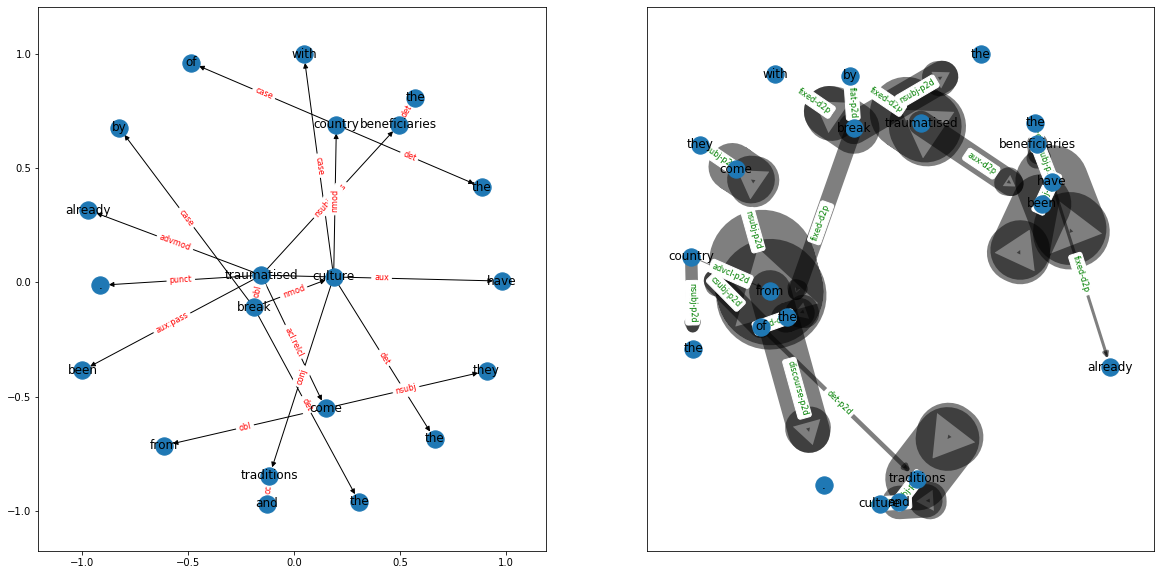

In [17]:
pred1, gold, r, ad  = multigraph_aborescene(5, visualize=True)

In [19]:
pospos_fram = dependency.conllu2pp_frame(conllu_train_file)

In [20]:
pospos_fram

,ADJ,ADP,ADV,DET,NOUN,PUNCT,UNK,VERB
ADJ,2198,1,86,15,36189,8,430,7716
ADP,1922,224,346,296,56863,2,166,1906
ADV,4716,5,2261,60,4213,31,66,13545
DET,735,0,123,44,55668,2,24,460
NOUN,3806,336,464,296,73373,160,308,92488
PUNCT,1088,7,116,46,16027,2,419,38245
UNK,3794,47,451,55,14235,39,265,28337
VERB,1409,24,170,92,16224,66,58,50367


In [104]:
sent_pos = np.zeros((len(pospos_fram.columns),len(pred1) ))
sent_pos[pos2ord['VERB'],r] = 1.
curr_nodes = [r]
transition_matrix = pospos_fram.values / pospos_fram.values.sum(axis=0, keepdims = True)
while curr_nodes:
    new_nodes = []
    for n in curr_nodes:
        for dep in ad[n]:
            i = pos2ord[dependency.transform_label2pos(pred1[n,dep][:-4])]
            sent_pos[i,dep] = 1
            #sent_pos[:,dep] =  np.dot(transition_matrix,sent_pos[:,n] )
            new_nodes.append(dep)
    curr_nodes = new_nodes

In [122]:
sent_pos

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0.]])

In [106]:
sent_pos = np.zeros((len(pospos_fram.columns),len(pred1) ))
for d, h, l, p in dependency_rels[5]:
    jdx = pos2ord[dependency.transform_pos(p)]
    sent_pos[jdx,d] = 1

In [107]:
sent_pos[:,:5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1.]])

In [88]:
pospos_fram = dependency.conllu2pp_frame(conllu_train_file)

In [125]:
pospos_fram

,ADJ,ADV,NOUN,UNK,DET,ADP,PUNCT,VERB
ADJ,2198,86,36189,430,15,1,8,7716
ADV,4716,2261,4213,66,60,5,31,13545
NOUN,3806,464,73373,308,296,336,160,92488
UNK,3794,451,14235,265,55,47,39,28337
DET,735,123,55668,24,44,0,2,460
ADP,1922,346,56863,166,296,224,2,1906
PUNCT,1088,116,16027,419,46,7,2,38245
VERB,1409,170,16224,58,92,24,66,50367


In [128]:
pospos_fram['ADJ']['NOUN'] += 1

In [129]:
pospos_fram.values

array([[ 2198,    86, 36189,   430,    15,     1,     8,  7716],
       [ 4716,  2261,  4213,    66,    60,     5,    31, 13545],
       [ 3807,   464, 73373,   308,   296,   336,   160, 92488],
       [ 3794,   451, 14235,   265,    55,    47,    39, 28337],
       [  735,   123, 55668,    24,    44,     0,     2,   460],
       [ 1922,   346, 56863,   166,   296,   224,     2,  1906],
       [ 1088,   116, 16027,   419,    46,     7,     2, 38245],
       [ 1409,   170, 16224,    58,    92,    24,    66, 50367]])

In [114]:
import json

In [123]:
with open('/tmp/pos_frame.json', 'w') as ofile:
    json.dump(sent_pos, ofile)

TypeError: Object of type 'ndarray' is not JSON serializable

In [121]:
pd.DataFrame(pospos_fram.to_dict())

,ADJ,ADV,NOUN,UNK,DET,ADP,PUNCT,VERB
ADJ,2198,86,36189,430,15,1,8,7716
ADV,4716,2261,4213,66,60,5,31,13545
NOUN,3806,464,73373,308,296,336,160,92488
UNK,3794,451,14235,265,55,47,39,28337
DET,735,123,55668,24,44,0,2,460
ADP,1922,346,56863,166,296,224,2,1906
PUNCT,1088,116,16027,419,46,7,2,38245
VERB,1409,170,16224,58,92,24,66,50367


In [25]:
(np.array(list(map(int,gold.ravel()!='no edge')))*np.array(list(map(int,pred1.ravel()!='no edge')))).sum()

9

In [109]:
(np.array(list(map(int,gold.ravel()!='no edge')))*np.array(list(map(int,pred.ravel()!='no edge')))).sum()

11

In [110]:
np.array(list(map(int,gold.ravel()!='no edge'))).sum()

20

In [111]:
(np.array(list(map(int,gold.ravel()!='no edge')))*np.array(list(map(int,pred1.ravel()!='no edge')))).sum()/np.array(list(map(int,gold.ravel()!='no edge'))).sum()

0.45

In [66]:
cmlabs = list(set(pred1.ravel()).union(set(gold.ravel())))
# cmlabs.remove('no edge')
print_cm(confusion_matrix(pred1.ravel(),gold.ravel(),cmlabs), cmlabs)


          deter other adv-m punct no ed num-m auxil subje adj-c compo noun- appos conju 
    deter   2.0   2.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
    other   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0 
    adv-m   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
    punct   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
    no ed   1.0   6.0   0.0   1.0 410.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   1.0 
    num-m   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
    auxil   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
    subje   0.0   0.0   0.0   0.0   4.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0 
    adj-c   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
    compo   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
    noun-   0.0   0.0

In [87]:
pospos_fram/ pospos_fram.sum(axis=1)[:,None]

,ADJ,ADV,NOUN,UNK,DET,ADP,PUNCT,VERB
ADJ,0.047124,0.001844,0.775872,0.009219,0.000322,0.000021,0.000172,0.165427
ADV,0.189420,0.090814,0.169217,0.002651,0.002410,0.000201,0.001245,0.544041
NOUN,0.022227,0.002710,0.428503,0.001799,0.001729,0.001962,0.000934,0.540136
UNK,0.080342,0.009550,0.301442,0.005612,0.001165,0.000995,0.000826,0.600068
DET,0.012882,0.002156,0.975673,0.000421,0.000771,0.000000,0.000035,0.008062
ADP,0.031138,0.005606,0.921231,0.002689,0.004795,0.003629,0.000032,0.030879
PUNCT,0.019446,0.002073,0.286452,0.007489,0.000822,0.000125,0.000036,0.683557
VERB,0.020596,0.002485,0.237158,0.000848,0.001345,0.000351,0.000965,0.736252


In [130]:
conditional_matrix = pospos_fram.values / pospos_fram.values.sum(axis=1, keepdims=True)
x_prob = pospos_fram.values.sum(axis=0,keepdims=True)/pospos_fram.values.sum()

In [131]:
x_prob

array([[0.03689303, 0.00753466, 0.51167432, 0.0032562 , 0.00169563,
        0.00120795, 0.00058147, 0.43715675]])

In [77]:
pospos_fram[:] = 1

In [82]:
pospos_fram.values.sum(axis=0, keepdims=True)

array([[1., 1., 1., 1., 1., 1., 1., 1.]])

In [83]:
pospos_fram.values.sum(axis=1, keepdims=True)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [81]:
pospos_fram / (pospos_fram.values.sum(axis=0, keepdims=True) * pospos_fram.values.mean(axis=1, keepdims=True))

,ADJ,ADV,NOUN,UNK,DET,ADP,PUNCT,VERB
ADJ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ADV,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
NOUN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
UNK,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DET,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ADP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
PUNCT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
VERB,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [33]:
sent_pos[:, -4:]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.]])

In [63]:
from importlib import reload
from tools import dependency
dependency = reload(dependency)

In [112]:
def multigraph_aborescene_next(sentence, pos_frame, pos_probs, visualize=False):
    sentences = [sentence]
    attention_gen = sentence_attentions.generate_matrices(attentions_loaded,
                                                          tokens_grouped, eos,
                                                          no_softmax, maxlen,sentences)
    
    pos2ord = {pos: i for i, pos in enumerate(pos_frame.columns)}
    conditional_matrix = pos_frame.values / pos_frame.values.sum(axis=1, keepdims=True)
    x_prob = pos_frame.values.sum(axis=0,keepdims=True)/pos_frame.values.sum()
    #print(conditional_matrix.sum(axis=1, keepdims=True))
    viss = {sentence_idx: att_mts for att_mts, sentence_idx in attention_gen}
    

    sentence_index = sentence
    matrices = viss[sentence_index]
    
    
    words_list = common_tokens[sentence_index]
    words = ' '.join(words_list)

    edge_labeled = {(h, d) : l for d, h, l, p in dependency_rels[sentence_index] if l != 'root'}
    root_ord = 0
    for d, h, l, p in dependency_rels[sentence_index]:
        if l == 'root':
            root_ord = d
            break    
    
    token2pos = {d : p for d, h, l, p in dependency_rels[sentence_index]}
    DG=nx.DiGraph()
    DG.add_edges_from(edge_labeled.keys())
    
    labels = {}
    for node in DG.nodes():
        labels[node] = words_list[node]
    posG = nx.spring_layout(DG)

    MultiAttention = nx.MultiDiGraph()
    MultiAttention.add_nodes_from(DG.nodes())

    N_rels = len(relation_rules)
    N_toks = len(words_list)
    multi_edge2label = dict()
#     aggr_matrix_all= np.zeros((N_rels, N_toks, N_toks)) 

#     i = 0
    for relation, rules in relation_rules.items():
        y_ord = pos2ord[dependency.transform_label2pos(relation[:-4])]
        
        y_prob = (conditional_matrix[y_ord, np.newaxis]*x_prob).sum(axis=1, keepdims=True)
        #x_prob = np.dot(conditional_matrix,pos_probs).sum(axis=0, keepdims=True)
        xy_prob = np.dot(conditional_matrix,pos_probs)[y_ord, np.newaxis]
        

        prob_matrix = xy_prob / y_prob
        prob_matrix = prob_matrix.transpose()
        #np.fill_diagonal(prob_matrix, 0.001)
        print(prob_matrix)
        #prob_matrix[:,root_ord]=0.001
        #mat0 = np.dot(conditional_matrix[y_ord, np.newaxis], pos_probs)
        
        aggr_matrix = np.mean(np.array(matrices)[rules.layers,rules.heads,:,:], axis=0)
        np.fill_diagonal(aggr_matrix, 0.001)
        
        if rules.d2p == True:
            aggr_matrix = aggr_matrix.transpose()

        aggr_matrix[:,root_ord] = 0.001
#         aggr_matrix = np.log((aggr_matrix*mat0.transpose())/(1-aggr_matrix*mat0.transpose()))
        

#         mat1 = np.dot(conditional_matrix[y_ord, np.newaxis] * np.log(np.clip(conditional_matrix[y_ord, np.newaxis], 0.001,1)),pos_probs)

#         mat2 = mat0 * np.log(np.clip(pos_probs[y_ord,np.newaxis], 0.001,1))

#         mat3 =  1 * mat1.transpose() - 1 * mat2.transpose() + mat0 *  aggr_matrix

#         print(mat3.shape)

        total_matrix = 0.5* np.log(prob_matrix) + 1* np.log(aggr_matrix)
        AG = nx.from_numpy_matrix(total_matrix, create_using=nx.DiGraph)

        for u, v, d in AG.edges(data=True):
            multi_edge2label[(u,v,d['weight'])] = relation
        # incldue statistical info about pos:

        MultiAttention.add_edges_from(AG.edges(data=True), label=relation)
        
    AttentionAborescene = tree.branchings.maximum_spanning_arborescence(MultiAttention)
    espanning = AttentionAborescene.edges(data=True)
    weights = [max(np.exp(d['weight']), 1) for _,_,d in espanning]
    attention_labels  = {(u,v) : multi_edge2label[(u,v,d['weight'])] for u, v, d in espanning}

    espanning = [(u, v) for (u, v, d) in espanning]
    posA = nx.spring_layout(AttentionAborescene)

    if visualize:
            
        print(words)
        print(list(AttentionAborescene.edges(data=True)))
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))


        nx.draw_networkx_nodes(DG, posG, ax=ax1)
        nx.draw_networkx_edges(DG, posG, ax=ax1)
        nx.draw_networkx_labels(DG, posG,labels, font_size=12, ax=ax1)
        nx.draw_networkx_edge_labels(DG,posG,edge_labels= edge_labeled, font_size=8,font_color='red', ax=ax1)

        nx.draw_networkx_nodes(MultiAttention, posA, ax=ax2)
        nx.draw_networkx_edges(MultiAttention, posA,edgelist=espanning,  alpha=0.5,width=weights, ax=ax2)
        nx.draw_networkx_edge_labels(MultiAttention,posA,edge_labels=attention_labels,
                                     font_color='green',font_size=8, ax=ax2)
        nx.draw_networkx_labels(MultiAttention, posA,labels, font_size=12, ax=ax2)


        plt.show()
    
    alabelm = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge', dtype='U24')
    alabelm2 = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge', dtype='U24')
    dlabelm = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge', dtype='U24')
    
    
    aparent2deps = defaultdict(list)
    for aedge, ael in attention_labels.items():
        #if relation_rules[ael].d2p:
        
        alabelm[aedge[0], aedge[1]] = ael
        
        aparent2deps[aedge[0]].append(aedge[1])
#         else:
#             alabelm[aedge[1],aedge[0]] = ael

        
    for dedge, deel in edge_labeled.items():

        deel = dependency.transform_label(deel)

        if deel  + '-d2p' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = deel  + '-d2p'
        elif deel + '-p2d' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = deel  + '-p2d'
            
        elif 'other-d2p' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = 'other-d2p'
        elif 'other-p2d' in relation_rules:
            dlabelm[dedge[1], dedge[0]] = 'other-p2d'
            
    return alabelm, dlabelm, root_ord, aparent2deps

In [100]:
pospos_fram

,ADJ,ADV,NOUN,UNK,DET,ADP,PUNCT,VERB
ADJ,2198,86,36189,430,15,1,8,7716
ADV,4716,2261,4213,66,60,5,31,13545
NOUN,3806,464,73373,308,296,336,160,92488
UNK,3794,451,14235,265,55,47,39,28337
DET,735,123,55668,24,44,0,2,460
ADP,1922,346,56863,166,296,224,2,1906
PUNCT,1088,116,16027,419,46,7,2,38245
VERB,1409,170,16224,58,92,24,66,50367


[[0.00277556]
 [0.71836504]
 [1.43001828]
 [0.02275958]
 [1.43001828]
 [1.43001828]
 [0.00237184]
 [0.00277556]
 [0.71836504]
 [0.00237184]
 [0.00277556]
 [0.71836504]
 [0.01337315]
 [0.71836504]
 [0.00237184]
 [0.00277556]
 [0.71836504]
 [0.71836504]
 [1.43001828]
 [0.00237184]
 [0.00196812]]
[[6.82646952e-04]
 [1.64695404e+00]
 [3.51153592e-01]
 [3.91384252e-03]
 [3.51153592e-01]
 [3.51153592e-01]
 [4.55097968e-05]
 [6.82646952e-04]
 [1.64695404e+00]
 [4.55097968e-05]
 [6.82646952e-04]
 [1.64695404e+00]
 [1.95692126e-02]
 [1.64695404e+00]
 [4.55097968e-05]
 [6.82646952e-04]
 [1.64695404e+00]
 [1.64695404e+00]
 [3.51153592e-01]
 [4.55097968e-05]
 [3.64078374e-04]]
[[0.00277556]
 [0.71836504]
 [1.43001828]
 [0.02275958]
 [1.43001828]
 [1.43001828]
 [0.00237184]
 [0.00277556]
 [0.71836504]
 [0.00237184]
 [0.00277556]
 [0.71836504]
 [0.01337315]
 [0.71836504]
 [0.00237184]
 [0.00277556]
 [0.71836504]
 [0.71836504]
 [1.43001828]
 [0.00237184]
 [0.00196812]]
[[7.25659317e-03]
 [5.09533784e

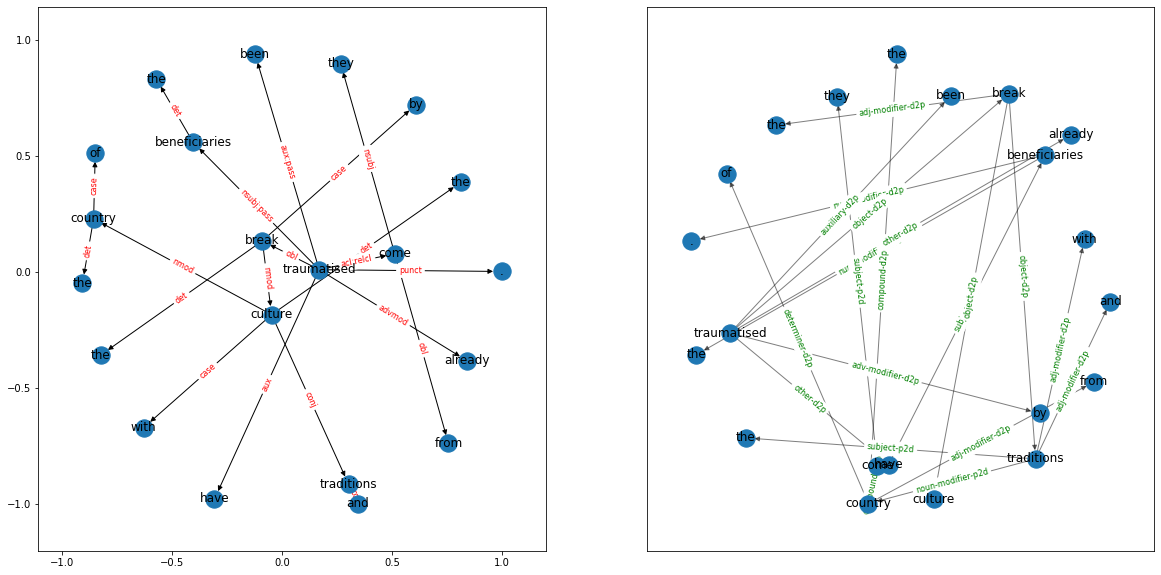

In [113]:
pred, gold, r, ad  = multigraph_aborescene_next(5, pospos_fram, sent_pos, visualize=True)

In [72]:
np.clip(np.arange(9), 3, 8)

array([3, 3, 3, 3, 4, 5, 6, 7, 8])

## UDAPI

In [26]:
from udapi.core.document import Document
from udapi.block.read.conllu import Conllu
from udapi.core.node import Node

from copy import copy

In [27]:
reverse_label_map = {value: key for key, value in dependency.label_map.items()}
reverse_label_map['other'] = 'dep'

In [28]:
doc = Document()
doc.load_conllu(conllu_file_name)


In [29]:
bund =  doc.bundles[0]

In [30]:
roo = bund.get_tree()

In [31]:
roo.zone = 'silver'

In [32]:
bund.get_tree('silver')

In [91]:
def rewrite_conllu(conllu_file, conllu_out_file, predictions=True):
    CONLLU_ID = 0
    CONLLU_LABEL = 7
    CONLLU_HEAD = 6
    CONLLU_POS = 3
    relations_labeled = []
    sentence_rel = []
    out_lines = []
    with open(conllu_file, 'r') as in_conllu:
        sentid = 0
        pred, gold = multigraph_aborescene(sentid, visualize=False)
        for line in in_conllu:
            if sentid > 30:
                break
            if line == '\n':
                out_lines.append(line.strip())
                sentid += 1
                pred, gold = multigraph_aborescene(sentid, visualize=False)
            elif line.startswith('#'):
                if line.startswith('# sent_id'):
                    if predictions:
                        out_lines.append(line.strip() + '/pred')
                    else:
                        out_lines.append(line.strip() + '/gold')
                out_lines.append(line.strip())
            else:
                fields = line.strip().split('\t')
                if fields[CONLLU_ID].isdigit():
                    if fields[CONLLU_LABEL].strip() != 'root':
                        if predictions:
                            col = pred.transpose()[int(fields[CONLLU_ID])-1]
                        else:
                            col = gold.transpose()[int(fields[CONLLU_ID])-1]
                        x  = np.argwhere(col!='no edge')
                        x = x.item()
                        lab = reverse_label_map[col[x][:-4]]
                        
                        fields[CONLLU_HEAD] = str(x+1)
                        fields[CONLLU_LABEL] = lab
                        
                out_lines.append('\t'.join(fields))
                
    with open(conllu_out_file, 'w') as out_conllu:
        out_conllu.write('\n'.join(out_lines))


In [92]:
rewrite_conllu(conllu_file_name,'../graph-extraction/endev-outp.conllu', predictions=True)

In [93]:
rewrite_conllu(conllu_file_name,'../graph-extraction/endev-outg.conllu', predictions=False)

In [33]:
doc = Document()
doc.load_conllu(conllu_file_name)

for idx, bund in tqdm(enumerate(doc.bundles)):
    roo_s = bund.get_tree()
    roo_s.zone = 'silver'
    roo_p = bund.create_tree('prediction')
    
    roo_p.form = roo_s.form
    roo_p.lemma = roo_s.lemma
    roo_p.upos = roo_s.upos
    roo_p.xpos = roo_s.xpos
    roo_p._misc = copy(roo_s._misc)
    roo_p._feats = copy(roo_s._feats)
    
    for node in roo_s.descendants():
        if node.deprel != '<ROOT>':
        new_node = Node(form=node.form, lemma=node.lemma, upos=node.upos,
                         xpos=node.xpos,  deprel='dep')
        new_node._misc = copy(node._misc)
        new_node._feats = copy(node._feats)
        new_node._parent = roo_p
        roo_p._children.append(new_node)
        roo_p._descendants.append(new_node)

            
    pred, _ =  multigraph_aborescene(idx)
    nodes = roo_p.descendants()
    print(len(nodes))
    for node, col in zip(nodes, pred.transpose()):
        if node.deprel != '<ROOT>':
            x  = np.argwhere(col!='no edge')
            print(x)
            x = x.item()
            lab = reverse_label_map[col[x][:-4]]
            
            node.parent = nodes[x]
            node.deprel = lab
            
    print(roo_p.compute_text())

0it [00:06, ?it/s]

47
[[1]]
[]


ValueError: can only convert an array of size 1 to a Python scalar

In [35]:
roo_s.text

"We talk about creating the world 's largest single market here , and we talk about making the EU the most competitive economy in the world , and we talk about the world competition , yet what do we do when it comes to tax competition ?"

In [36]:
roo_p.text

In [42]:
for node in roo_p._descendants:
    print(type(node))

<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class 'udapi.core.node.Node'>
<class '

In [32]:
doc.store_conllu('../graph-extraction/endev-out.conllu')

In [ ]:
# one matrix instead of many 


# no softmax before averaging required
def average_matrices(matrices,layers, heads, transpose=False):
    sel_matrices = matrices[layers,heads,:,:]
    if transpose:
        sel_matrices = sel_matrices.transpose([0, 2, 1])
    sel_matrices -= sel_matrices.max(axis=-1, keepdims=True)
    sel_matrices = np.exp(sel_matrices)
    sel_matrices = sel_matrices/sel_matrices.sum(axis=-1, keepdims=True)
    
    return np.mean(sel_matrices, axis=0)

def multigraph_aborescene(sentence, visualize=False):
    sentences = [sentence]
    attention_gen = sentence_attentions.generate_matrices(attentions_loaded,
                                                          tokens_grouped, eos,
                                                          no_softmax, maxlen,sentences)
    #attention_gen = enumerate(attention_gen)

    viss = {sentence_idx: att_mts for att_mts, sentence_idx in attention_gen}
    

    sentence_index = sentence
    matrices = viss[sentence_index]
    
#     matrices = np.array(matrices)
    
#     matrices -= matrices.max(axis=-1, keepdims=True).max(axis=-2, keepdims=True)
#     matrices = np.exp(matrices)
#     matrices = matrices / matrices.sum(axis=-1, keepdims=True).sum(axis=-2, keepdims=True)
    
    words_list = common_tokens[sentence_index]
    words = ' '.join(words_list)

    
    edge_labeled = {(h, d) : l for d, h, l, p in dependency_rels[sentence_index] if l != 'root'}
    root_ord = 0
    for d, h, l, p in dependency_rels[sentence_index]:
        if l == 'root':
            root_ord = d
            break
    
    
    token2pos = {d : p for d, h, l, p in dependency_rels[sentence_index]}
    DG=nx.DiGraph()
    DG.add_edges_from(edge_labeled.keys())
    
    labels = {}
    for node in DG.nodes():
        labels[node] = words_list[node]
    posG = nx.spring_layout(DG)


    MultiAttention = nx.MultiDiGraph()
    MultiAttention.add_nodes_from(DG.nodes())

    N_rels = len(relation_rules)
    N_toks = len(words_list)
    multi_edge2label = dict()
    aggr_matrix_all= np.zeros((N_rels, N_toks, N_toks)) 

    i = 0
    for relation, rules in relation_rules.items():
        aggr_matrix = np.mean(np.array(matrices)[rules.layers,rules.heads,:,:], axis=0)
        np.fill_diagonal(aggr_matrix, 0)
        
        if rules.d2p == True:
            aggr_matrix = aggr_matrix.transpose()
#         aggr_matrix = average_matrices(np.array(matrices), rules.layers, rules.heads, rules.d2p)
#         aggr_matrix
        aggr_matrix[:,root_ord] = 0
        aggr_matrix_all[i, :, :] = aggr_matrix
        i += 1
#        aggr_matrix /= aggr_matrix.sum(axis=1, keepdims=True)
#         dep_prob = aggr_matrix.mean(axis=0, keepdims=True)
#         dep_prob /= dep_prob.sum(axis=1, keepdims=True)
#         for i in range(len(aggr_matrix)):
#             for j in range(len(aggr_matrix)):
#                 if i!=j:
#                     aggr_matrix[i,j] *= pos_frame[relation][(token2pos[j],token2pos[i])]
#                     if pos_frame[relation][(token2pos[j],token2pos[i])] <= 0.05:
#                         aggr_matrix[i,j] = 0.0001
                    
#                     if rules.d2p:
                        
# #                         if pos_frame[relation][(token2pos[i],token2pos[j])] <= 0.01:
# #                             aggr_matrix[i,j] = 0
#                         aggr_matrix[i,j] *= pos_frame[relation][(token2pos[i],token2pos[j])]

#                     else:
# #                         if pos_frame[relation][(token2pos[j],token2pos[i])] <= 0.01:
# #                             aggr_matrix[i,j] = 0
#                         aggr_matrix[i,j] *= pos_frame[relation][(token2pos[j],token2pos[i])]

#         AG = nx.from_numpy_matrix(aggr_matrix, create_using=nx.DiGraph)

#         for u, v, d in AG.edges(data=True):
#             multi_edge2label[(u,v,d['weight'])] = relation
#         # incldue statistical info about pos:

#         MultiAttention.add_edges_from(AG.edges(data=True), label=relation)
    aggr_matrix_mean = np.mean(aggr_matrix_all, axis=0)
    aggr_matrix_argmax = np.argmax(aggr_matrix_all, axis=0)

    
    
    AG = nx.from_numpy_matrix(aggr_matrix, create_using=nx.DiGraph)

    # MultiAttention.add_edges_from(AG.edges(data=True), label=relation)
        

    #AttentionAborescene = tree.branchings.maximum_spanning_arborescence(MultiAttention)
    AttentionAborescene = tree.branchings.maximum_spanning_arborescence(AG)
    espanning = AttentionAborescene.edges(data=True)
    weights = [max(d['weight'] *20, 1) for _,_,d in espanning]
    #attention_labels  = {(u,v) : multi_edge2label[(u,v,d['weight'])] for u, v, d in espanning}
    relation_rules_labels = list(relation_rules.keys())
    attention_labels = { (u,v): relation_rules_labels[aggr_matrix_argmax[u,v]] for u,v,_ in espanning}
    espanning = [(u, v) for (u, v, d) in espanning]
    posA = nx.spring_layout(AttentionAborescene)

    if visualize:
            
        print(words)
        print(list(AttentionAborescene.edges(data=True)))
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))


        nx.draw_networkx_nodes(DG, posG, ax=ax1)
        nx.draw_networkx_edges(DG, posG, ax=ax1)
        nx.draw_networkx_labels(DG, posG,labels, font_size=12, ax=ax1)
        nx.draw_networkx_edge_labels(DG,posG,edge_labels= edge_labeled, font_size=8,font_color='red', ax=ax1)

        nx.draw_networkx_nodes(MultiAttention, posA, ax=ax2)
        nx.draw_networkx_edges(MultiAttention, posA,edgelist=espanning,  alpha=0.5,width=weights, ax=ax2)
        nx.draw_networkx_edge_labels(MultiAttention,posA,edge_labels=attention_labels,
                                     font_color='green',font_size=8, ax=ax2)
        nx.draw_networkx_labels(MultiAttention, posA,labels, font_size=12, ax=ax2)


        plt.show()
    
    alabelm = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge', dtype='U24')
    alabelm2 = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge', dtype='U24')
    dlabelm = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge', dtype='U24')
    
    for aedge, ael in attention_labels.items():
        #if relation_rules[ael].d2p:
        
        alabelm[aedge[0], aedge[1]] = ael
#         else:
#             alabelm[aedge[1],aedge[0]] = ael

        
    for dedge, deel in edge_labeled.items():

        deel = dependency.transform_label(deel)

        if deel  + '-d2p' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = deel  + '-d2p'
        elif deel + '-p2d' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = deel  + '-p2d'
            
        elif 'other-d2p' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = 'other-d2p'
        elif 'other-p2d' in relation_rules:
            dlabelm[dedge[1], dedge[0]] = 'other-p2d'
            
    return alabelm, dlabelm